In [1]:
#Importing packages
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

## LOADING THE PRICE DATA

In [2]:
#Defining the stock --> MSFT = Microsoft
msft = yf.Ticker("MSFT")

In [3]:
#Stock information
msft.info

{'zip': '98052-6399',
 'sector': 'Technology',
 'fullTimeEmployees': 181000,
 'longBusinessSummary': 'Microsoft Corporation develops, licenses, and supports software, services, devices, and solutions worldwide. Its Productivity and Business Processes segment offers Office, Exchange, SharePoint, Microsoft Teams, Office 365 Security and Compliance, and Skype for Business, as well as related Client Access Licenses (CAL); Skype, Outlook.com, OneDrive, and LinkedIn; and Dynamics 365, a set of cloud-based and on-premises business solutions for organizations and enterprise divisions. Its Intelligent Cloud segment licenses SQL, Windows Servers, Visual Studio, System Center, and related CALs; GitHub that provides a collaboration platform and code hosting service for developers; and Azure, a cloud platform. It also offers support services and Microsoft consulting services to assist customers in developing, deploying, and managing Microsoft server and desktop solutions; and training and certifica

In [4]:
#Importing the historic price action
#hist = msft.history(period="max", interval="1wk")
hist = msft.history(period="max", interval="1d")
#hist = msft.history(period="2y", interval="1h")
#hist = msft.history(period="2y", interval="15m")
#hist = msft.history(period="2y", interval="5m")

In [5]:
#Visualising the data
hist

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
1986-03-13,0.055783,0.063987,0.055783,0.061252,1031788800,0.0,0.0
1986-03-14,0.061252,0.064533,0.061252,0.063439,308160000,0.0,0.0
1986-03-17,0.063439,0.065080,0.063439,0.064533,133171200,0.0,0.0
1986-03-18,0.064533,0.065080,0.062345,0.062892,67766400,0.0,0.0
1986-03-19,0.062892,0.063439,0.061252,0.061799,47894400,0.0,0.0
...,...,...,...,...,...,...,...
2022-04-11,291.790009,292.609985,285.000000,285.260010,34569300,0.0,0.0
2022-04-12,289.239990,290.739990,280.489990,282.059998,30966700,0.0,0.0
2022-04-13,282.730011,288.579987,281.299988,287.619995,21907200,0.0,0.0


In [6]:
#Formatting and slicing the data to contain OHLC and Volume
data = np.array(hist, dtype = float)
data = data[:,:5]

Text(0, 0.5, 'Price ($)')

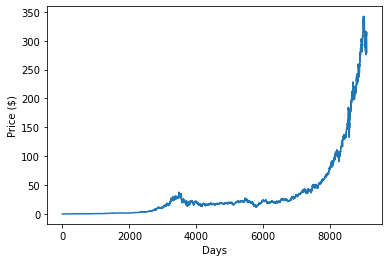

In [7]:
#Plotting the historical close prices
plt.plot(data[:,3])
plt.xlabel("Days")
plt.ylabel("Price ($)")

---

## DEFINING THE INDICATORS

In [8]:
#Moving Average function (MA)

def MA(dataset, timeframe_MA):

    Moving_Average = np.zeros(len(dataset))
    Moving_Average[:timeframe_MA-1] = "NaN"
    
    for i in range(timeframe_MA-1, len(dataset)):
        Moving_Average[i] = np.mean(dataset[i-timeframe_MA+1:i+1])
        
    return Moving_Average

In [9]:
#Exponential Moving Average function (EMA)

def EMA(dataset, MA, timeframe_EMA):

    Exponential_Moving_Average = np.zeros(len(dataset))
    Exponential_Moving_Average[:timeframe_EMA-1] = "NaN"
    Exponential_Moving_Average[timeframe_EMA-1] = MA[timeframe_EMA-1]
    
    multiplier = 2/(timeframe_EMA+1)
    
    for i in range(timeframe_EMA, len(dataset)):
        Exponential_Moving_Average[i] = (dataset[i] * multiplier) + (Exponential_Moving_Average[i-1] * (1-multiplier))
        
    return Exponential_Moving_Average

In [10]:
#Relative Strength Index function (RSI)

def RSI(dataset, timeframe_RSI):
    
    RSI = np.zeros(len(dataset))
    RSI[:timeframe_RSI] = "NaN"
    
    #for i in timeframe_RSI:
        
    gain = np.zeros(timeframe_RSI)
    loss = np.zeros(timeframe_RSI)
        
    for j in range(1, timeframe_RSI+1):
            
        if dataset[j] > dataset[j-1]:
            gain[j-1] = dataset[j] - dataset[j-1]
        elif dataset[j] < dataset[j-1]:
            loss[j-1] = dataset[j-1] - dataset[j]
            
    avg_gain = sum(gain) / timeframe_RSI
    avg_loss = sum(loss) / timeframe_RSI
    RS = avg_gain / avg_loss
    RSI[timeframe_RSI] = 100 - (100/(1+RS))
    
    for i in range(timeframe_RSI+1, len(dataset)):
        
        if dataset[i] > dataset[i-1]:
            
            avg_gain = (avg_gain*(timeframe_RSI-1)+(dataset[i] - dataset[i-1])) / timeframe_RSI
            avg_loss = (avg_loss*(timeframe_RSI-1)) / timeframe_RSI
            RS = avg_gain / avg_loss
            RSI[i] = 100 - (100/(1+RS))
            
        elif dataset[i] < dataset[i-1]:
            
            avg_gain = (avg_gain*(timeframe_RSI-1)) / timeframe_RSI
            avg_loss = (avg_loss*(timeframe_RSI-1)+(dataset[i-1] - dataset[i])) / timeframe_RSI
            RS = avg_gain / avg_loss
            RSI[i] = 100 - (100/(1+RS))
        
        else:
            
            avg_gain = (avg_gain*(timeframe_RSI-1)) / timeframe_RSI
            avg_loss = (avg_loss*(timeframe_RSI-1)) / timeframe_RSI
            RS = avg_gain / avg_loss
            RSI[i] = 100 - (100/(1+RS))
    
    return RSI

In [11]:
#Stochastic Relative Strength Index function (Stochastic RSI)

def STOCH_RSI(dataset, timeframe_RSI, timeframe_K, timeframe_D):
    
    RSI_NEEDED = RSI(dataset, timeframe_RSI)
    
    STOCH_RSI_K = np.zeros(len(dataset))
    STOCH_RSI_D = np.zeros(len(dataset))
    
    STOCH_RSI_K[:timeframe_RSI+timeframe_K] = "NaN"
    STOCH_RSI_D[:timeframe_RSI+timeframe_K+timeframe_D] = "NaN"
    
    for i in range(timeframe_RSI+timeframe_K, len(dataset)):
        
        STOCH_RSI_K[i] = 100 * (RSI_NEEDED[i] - (min(RSI_NEEDED[i-timeframe_K+1:i+1]))) / ((max(RSI_NEEDED[i-timeframe_K+1:i+1])) - (min(RSI_NEEDED[i-timeframe_K+1:i+1])))
    
    STOCH_RSI_D[timeframe_RSI:] = MA(STOCH_RSI_K[timeframe_RSI:], timeframe_D)
    
    return STOCH_RSI_K, STOCH_RSI_D

In [12]:
#Moving Average Convergence Divergence function (MACD)

def MACD(dataset, timeframe_1_MACD, timeframe_2_MACD, timeframe_3_MACD):

    MACD_Value = np.zeros(len(dataset))
    Signal_Line = np.zeros(len(dataset))
    MACD_Histogram = np.zeros(len(dataset))
    
    MACD_Value[:timeframe_2_MACD] = "NaN"
    Signal_Line[:timeframe_2_MACD+timeframe_3_MACD] = "NaN"
    MACD_Histogram[:timeframe_2_MACD+timeframe_3_MACD] = "NaN"
    
    MA_12 = MA(dataset, timeframe_1_MACD)
    MA_26 = MA(dataset, timeframe_2_MACD)
    
    EMA_12 = EMA(dataset, MA_12, timeframe_1_MACD)
    EMA_26 = EMA(dataset, MA_26, timeframe_2_MACD)
    
    
    MACD_Value[timeframe_2_MACD:] = EMA_12[timeframe_2_MACD:] - EMA_26[timeframe_2_MACD:]
    
    Signal_Line[timeframe_2_MACD:] = MA(MACD_Value[timeframe_2_MACD:], timeframe_3_MACD)
    
    MACD_Histogram = MACD_Value - Signal_Line
        
    return MACD_Value, Signal_Line, MACD_Histogram

In [13]:
#Bollinger Bands (BB)

def BB(dataset, timeframe_BB, BB_Std):

    BB_UP = np.zeros(len(dataset))
    BB_DOWN = np.zeros(len(dataset))
    
    BB_UP[:timeframe_BB-1] = "NaN"
    BB_DOWN[:timeframe_BB-1] = "NaN"
    
    MA_20 = MA(dataset, timeframe_BB)
    
    for i in range(timeframe_BB-1, len(dataset)):
        BB_UP[i] = MA_20[i] + 2*(np.std(dataset[i-timeframe_BB+1:i+1]))
        BB_DOWN[i] = MA_20[i] - 2*(np.std(dataset[i-timeframe_BB+1:i+1]))
        
    return BB_UP, MA_20, BB_DOWN

In [14]:
#Average Directional Movement Index (ADX)

def ADX(dataset_OHLC, timeframe_ADX):
    
    #Calculating TR
    M1 = np.zeros(len(dataset_OHLC[:,0]))
    M2 = np.zeros(len(dataset_OHLC[:,0]))
    M3 = np.zeros(len(dataset_OHLC[:,0]))
    M2[0] = "NaN"
    M3[0] = "NaN"
    
    M1 = dataset_OHLC[:,1] - dataset_OHLC[:,2]
    for i in range(1,len(dataset_OHLC[:,0])):
        M2[i] = abs(dataset_OHLC[i,1] - dataset_OHLC[i-1,3])
        M3[i] = abs(dataset_OHLC[i,2] - dataset_OHLC[i-1,3])
        
    TR = np.zeros(len(dataset_OHLC[:,0]))
    TR[0] = "NaN"
    for i in range(1,len(dataset_OHLC[:,0])):
        TR[i] = max(M1[i],M2[i],M3[i])
    
    #Calculating ATR
    ATR = np.zeros(len(dataset_OHLC[:,0]))
    ATR[:timeframe_ADX] = "NaN"
    ATR[timeframe_ADX] = np.mean(TR[1:timeframe_ADX])
    for i in range(timeframe_ADX+1,len(dataset_OHLC[:,0])):
        ATR[i] = ((ATR[i-1]*(timeframe_ADX-1))+TR[i])/timeframe_ADX
    
    #Calculating +DX and -DX
    H_pH = np.zeros(len(dataset_OHLC[:,0]))
    pL_L = np.zeros(len(dataset_OHLC[:,0]))
    H_pH[0] = "NaN"
    pL_L[0] = "NaN"
    for i in range(1,len(dataset_OHLC[:,0])):
        H_pH[i] = dataset_OHLC[i,1] - dataset_OHLC[i-1,1]
        pL_L[i] = dataset_OHLC[i,2] - dataset_OHLC[i-1,2]
    
    DX_P = np.zeros(len(dataset_OHLC[:,0]))
    DX_N = np.zeros(len(dataset_OHLC[:,0]))
    DX_P[0] = "NaN"
    DX_N[0] = "NaN"
    for i in range(1,len(dataset_OHLC[:,0])):
        if H_pH[i] > pL_L[i]:
            DX_N[i] = 0
            if H_pH[i] > 0:
                DX_P[i] = H_pH[i]
            else:
                DX_P[i] = 0
        elif H_pH[i] < pL_L[i]:
            DX_P[i] = 0
            if pL_L[i] > 0:
                DX_N[i] = pL_L[i]
            else:
                DX_N[i] = 0
        else:
            DX_P[i] = 0
            DX_N[i] = 0
    
    #Calculating smooth +DX and -DX
    Smooth_DX_P = np.zeros(len(dataset_OHLC[:,0]))
    Smooth_DX_N = np.zeros(len(dataset_OHLC[:,0]))
    Smooth_DX_P[:timeframe_ADX] = "NaN"
    Smooth_DX_N[:timeframe_ADX] = "NaN"
    Smooth_DX_P[timeframe_ADX] = np.mean(DX_P[1:timeframe_ADX])
    Smooth_DX_N[timeframe_ADX] = np.mean(DX_N[1:timeframe_ADX])
    for i in range(timeframe_ADX+1,len(dataset_OHLC[:,0])):
        Smooth_DX_P[i] = ((Smooth_DX_P[i-1]*(timeframe_ADX-1))+DX_P[i])/timeframe_ADX
        Smooth_DX_N[i] = ((Smooth_DX_N[i-1]*(timeframe_ADX-1))+DX_N[i])/timeframe_ADX
    
    #Calculating +DMI and -DMI
    DMI_P = np.zeros(len(dataset_OHLC[:,0]))
    DMI_N = np.zeros(len(dataset_OHLC[:,0]))
    DMI_P = (Smooth_DX_P/ATR)*100
    DMI_N = (Smooth_DX_N/ATR)*100
    
    #Calculating DX
    DX = np.zeros(len(dataset_OHLC[:,0]))
    DX[:timeframe_ADX] = "NaN"
    for i in range(timeframe_ADX,len(dataset_OHLC[:,0])):
        DX[i] = (abs(DMI_P[i]-DMI_N[i])/(DMI_P[i]+DMI_N[i])) * 100
    
    #Calculating ADX
    ADX = np.zeros(len(dataset_OHLC[:,0]))
    ADX[:2*timeframe_ADX] = "NaN"
    ADX[2*timeframe_ADX] = np.mean(DX[timeframe_ADX:2*timeframe_ADX])
    for i in range(2*timeframe_ADX+1,len(dataset_OHLC[:,0])):
        ADX[i] = ((ADX[i-1]*(timeframe_ADX-1)) + DX[i])/timeframe_ADX
    
    return ADX

---

## CALCULATING THE INDICATORS VALUES

In [15]:
#Defining the closing prices
close_price = data[:,3]
volume = data[:,4]

In [16]:
#Using the indicators functions

MA50 = MA(close_price, 50)                                          # 50-day Moving Average
EMA50 = EMA(close_price, MA50, 50)                                  # 50-day Exponential Moving Average

MA200 = MA(close_price, 200)                                        # 200-day Moving Average
EMA200 = EMA(close_price, MA200, 200)                               # 200-day Exponential Moving Average

RSI14 = RSI(close_price, 14)                                        # RSI

STOCH_K, STOCH_D = STOCH_RSI(close_price, 14, 14, 3)                # Stochastic RSI

MACD_VALUE, SIG_LINE, MACD_HIST = MACD(close_price, 12, 26, 9)      # MACD

BB_UP, BB_MID, BB_DOWN = BB(close_price, 20, 2)                     # Bollinger Bands

ADX14 = ADX(data, 14)                                               # ADX

---

## PLOTTING THE  PRICE WITH THE INDICATORS

---

### MAs and the EMAs

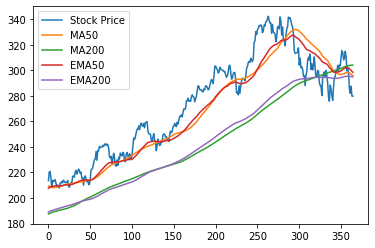

In [17]:
#Plotting the price action with the MAs and the EMAs

plt.plot(close_price[-365:], label="Stock Price")

plt.plot(MA50[-365:], label="MA50")
plt.plot(MA200[-365:], label="MA200")

plt.plot(EMA50[-365:], label="EMA50")
plt.plot(EMA200[-365:], label="EMA200")

plt.legend()

### Volume

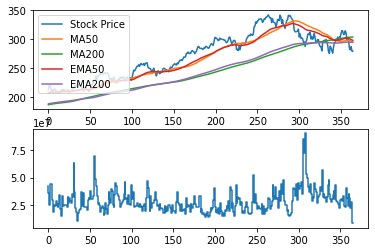

In [18]:
#Plotting the price action with the MAs, the EMAs and the Volume

plt.subplot(2,1,1)

plt.plot(close_price[-365:], label="Stock Price")

plt.plot(MA50[-365:], label="MA50")
plt.plot(MA200[-365:], label="MA200")

plt.plot(EMA50[-365:], label="EMA50")
plt.plot(EMA200[-365:], label="EMA200")

plt.legend()


plt.subplot(2,1,2)

plt.step(np.linspace(0, 365, 365), volume[-365:], drawstyle='steps-mid')

### RSI

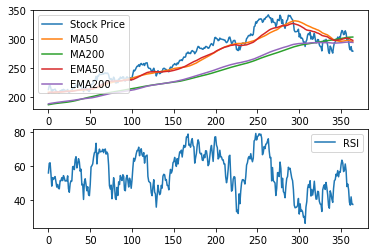

In [19]:
#Plotting the price action with the MAs, the EMAs and the RSI

plt.subplot(2,1,1)

plt.plot(close_price[-365:], label="Stock Price")

plt.plot(MA50[-365:], label="MA50")
plt.plot(MA200[-365:], label="MA200")

plt.plot(EMA50[-365:], label="EMA50")
plt.plot(EMA200[-365:], label="EMA200")

plt.legend()


plt.subplot(2,1,2)

plt.plot(RSI14[-365:], label="RSI")

plt.legend()

### Stochastic RSI

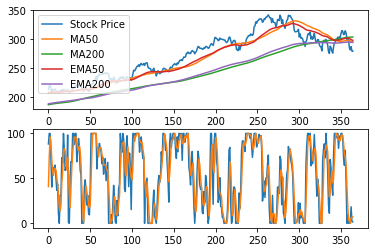

In [20]:
#Plotting the price action with the MAs, the EMAs and the Stochastic RSI

plt.subplot(2,1,1)

plt.plot(close_price[-365:], label="Stock Price")

plt.plot(MA50[-365:], label="MA50")
plt.plot(MA200[-365:], label="MA200")

plt.plot(EMA50[-365:], label="EMA50")
plt.plot(EMA200[-365:], label="EMA200")

plt.legend()


plt.subplot(2,1,2)

plt.plot(STOCH_K[-365:])
plt.plot(STOCH_D[-365:])

### MACD

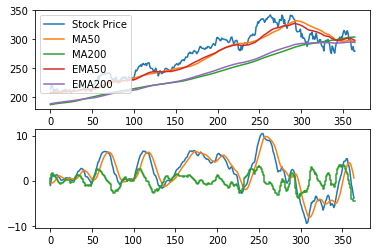

In [21]:
#Plotting the price action with the MAs, the EMAs and the MACD

plt.subplot(2,1,1)

plt.plot(close_price[-365:], label="Stock Price")

plt.plot(MA50[-365:], label="MA50")
plt.plot(MA200[-365:], label="MA200")

plt.plot(EMA50[-365:], label="EMA50")
plt.plot(EMA200[-365:], label="EMA200")

plt.legend()


plt.subplot(2,1,2)

plt.plot(MACD_VALUE[-365:])
plt.plot(SIG_LINE[-365:])
plt.step(np.linspace(0, 365, 365), MACD_HIST[-365:], drawstyle='steps-mid')

### Bollinger Bands

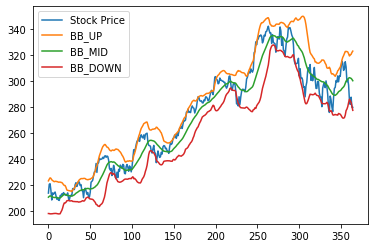

In [22]:
#Plotting the price action with the MAs, the EMAs and the Bollinger Bands

plt.plot(close_price[-365:], label="Stock Price")

plt.plot(BB_UP[-365:], label="BB_UP")
plt.plot(BB_MID[-365:], label="BB_MID")
plt.plot(BB_DOWN[-365:], label="BB_DOWN")

plt.legend()

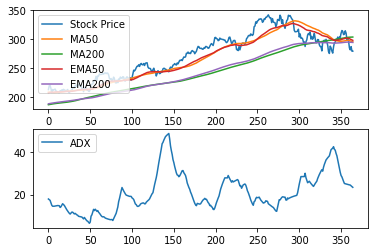

In [23]:
#Plotting the price action with the MAs, the EMAs and the ADX

plt.subplot(2,1,1)

plt.plot(close_price[-365:], label="Stock Price")

plt.plot(MA50[-365:], label="MA50")
plt.plot(MA200[-365:], label="MA200")

plt.plot(EMA50[-365:], label="EMA50")
plt.plot(EMA200[-365:], label="EMA200")

plt.legend()


plt.subplot(2,1,2)

plt.plot(ADX14[-365:], label="ADX")

plt.legend()

---

## CREATING THE OUTPUT FILE

In [24]:
#Creating the final dataset
Data_Stock = hist.drop(columns=['Dividends', 'Stock Splits'])
Data_Stock

,Open,High,Low,Close,Volume
Date,,,,,
1986-03-13,0.055783,0.063987,0.055783,0.061252,1031788800
1986-03-14,0.061252,0.064533,0.061252,0.063439,308160000
1986-03-17,0.063439,0.065080,0.063439,0.064533,133171200
1986-03-18,0.064533,0.065080,0.062345,0.062892,67766400
1986-03-19,0.062892,0.063439,0.061252,0.061799,47894400
...,...,...,...,...,...
2022-04-11,291.790009,292.609985,285.000000,285.260010,34569300
2022-04-12,289.239990,290.739990,280.489990,282.059998,30966700
2022-04-13,282.730011,288.579987,281.299988,287.619995,21907200


In [25]:
#Calculating if price goes up or down in the intervals
CHANGE = np.array([])

for i in range(0,len(close_price)-1):
    
    if close_price[i]<close_price[i+1]:
        CHANGE = np.append(CHANGE, "Up")
        
    elif close_price[i]>close_price[i+1]:
        CHANGE = np.append(CHANGE, "Down")
        
    else:
        CHANGE = np.append(CHANGE, "Equal")
        
CHANGE = np.append(CHANGE, "NaN")

In [26]:
#Including the calculated indicators in the file
Data_Stock["MA 50"] = MA50
Data_Stock["EMA 50"] = EMA50
Data_Stock["MA 200"] = MA200
Data_Stock["EMA 200"] = EMA200
Data_Stock["RSI 14"] = RSI14
Data_Stock["STOCH K"] = STOCH_K
Data_Stock["STOCH D"] = STOCH_D
Data_Stock["MACD VALUE"] = MACD_VALUE
Data_Stock["SIG LINE"] = SIG_LINE
Data_Stock["MACD HIST"] = MACD_HIST
Data_Stock["BB UP"] = BB_UP
Data_Stock["BB MID"] = BB_MID
Data_Stock["BB DOWN"] = BB_DOWN
Data_Stock["ADX"] = ADX14
Data_Stock["PRICE_CHANGE"] = CHANGE

Data_Stock

,Open,High,Low,Close,Volume,MA 50,EMA 50,MA 200,EMA 200,RSI 14,STOCH K,STOCH D,MACD VALUE,SIG LINE,MACD HIST,BB UP,BB MID,BB DOWN,ADX,PRICE_CHANGE
Date,,,,,,,,,,,,,,,,,,,,
1986-03-13,0.055783,0.063987,0.055783,0.061252,1031788800,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Up
1986-03-14,0.061252,0.064533,0.061252,0.063439,308160000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Up
1986-03-17,0.063439,0.065080,0.063439,0.064533,133171200,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Down
1986-03-18,0.064533,0.065080,0.062345,0.062892,67766400,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Down
1986-03-19,0.062892,0.063439,0.061252,0.061799,47894400,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Down
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-04-11,291.790009,292.609985,285.000000,285.260010,34569300,297.998370,301.315840,303.881537,295.381044,38.825869,0.000000,3.122670,0.621366,3.629642,-3.008276,319.406276,302.716501,286.026726,24.556318,Down
2022-04-12,289.239990,290.739990,280.489990,282.059998,30966700,297.432803,300.560709,303.956015,295.248496,37.087544,0.000000,0.000000,-0.949929,3.050548,-4.000478,320.214874,302.462001,284.709128,24.467079,Up
2022-04-13,282.730011,288.579987,281.299988,287.619995,21907200,297.022745,300.053230,304.044971,295.172591,41.950660,18.411233,6.137078,-1.726643,2.378691,-4.105335,320.717365,302.123500,283.529635,24.089670,Down


---

## SAVING AND LOADING CSV FILES

In [27]:
#Data_Stock.to_csv(r'Stock_Data_1d.csv')

In [28]:
test_input = pd.read_csv('Stock_Data_1d.csv',index_col=0)

FileNotFoundError: [Errno 2] No such file or directory: 'Stock_Data_1d.csv'

In [ ]:
test_input

,Open,High,Low,Close,Volume,MA 50,EMA 50,MA 200,EMA 200,RSI 14,STOCH K,STOCH D,MACD VALUE,SIG LINE,MACD HIST,BB UP,BB MID,BB DOWN,ADX,PRICE_CHANGE
Date,,,,,,,,,,,,,,,,,,,,
1986-03-13,0.055783,0.063987,0.055783,0.061252,1031788800,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Up
1986-03-14,0.061252,0.064533,0.061252,0.063439,308160000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Up
1986-03-17,0.063439,0.065080,0.063439,0.064533,133171200,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Down
1986-03-18,0.064533,0.065080,0.062345,0.062892,67766400,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Down
1986-03-19,0.062892,0.063439,0.061252,0.061799,47894400,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Down
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-04-06,305.190002,307.000000,296.709991,299.500000,40110400,298.385229,302.208180,303.425367,295.408497,47.996855,0.000000,42.461359,3.861674,3.784516,0.077158,322.839254,300.641501,278.443748,24.867374,Up
2022-04-07,296.660004,303.649994,296.350006,301.369995,31411200,298.490674,302.175310,303.613546,295.467816,49.449322,9.368011,18.462356,3.198827,3.974424,-0.775597,322.526632,301.430501,280.334370,24.755917,Down
2022-04-08,300.440002,301.119995,296.279999,296.970001,24347400,298.445648,301.971181,303.772665,295.482763,46.180919,0.000000,3.122670,2.292052,3.956223,-1.664171,321.114707,302.275500,283.436294,24.652421,Down


In [ ]:
Data_Stock.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 9096 entries, 1986-03-13 to 2022-04-12
Data columns (total 20 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Open          9096 non-null   float64
 1   High          9096 non-null   float64
 2   Low           9096 non-null   float64
 3   Close         9096 non-null   float64
 4   Volume        9096 non-null   int64  
 5   MA 50         9047 non-null   float64
 6   EMA 50        9047 non-null   float64
 7   MA 200        8897 non-null   float64
 8   EMA 200       8897 non-null   float64
 9   RSI 14        9082 non-null   float64
 10  STOCH K       9068 non-null   float64
 11  STOCH D       9066 non-null   float64
 12  MACD VALUE    9070 non-null   float64
 13  SIG LINE      9062 non-null   float64
 14  MACD HIST     9062 non-null   float64
 15  BB UP         9077 non-null   float64
 16  BB MID        9077 non-null   float64
 17  BB DOWN       9077 non-null   float64
 18  ADX       

---

## DATA PREPROCESSING

In [ ]:
#Including the calculated indicators in the file
Data_Stock["MA 50"] = MA50 / Data_Stock["Close"]
Data_Stock["EMA 50"] = EMA50 / Data_Stock["Close"]
Data_Stock["MA 200"] = MA200 / Data_Stock["Close"]
Data_Stock["EMA 200"] = EMA200 / Data_Stock["Close"]
Data_Stock["RSI 14"] = RSI14
Data_Stock["STOCH K"] = STOCH_K
Data_Stock["STOCH D"] = STOCH_D
Data_Stock["MACD VALUE"] = MACD_VALUE
Data_Stock["SIG LINE"] = SIG_LINE
Data_Stock["MACD HIST"] = MACD_HIST
Data_Stock["BB UP"] = BB_UP / Data_Stock["Close"]
Data_Stock["BB MID"] = BB_MID / Data_Stock["Close"]
Data_Stock["BB DOWN"] = BB_DOWN / Data_Stock["Close"]
Data_Stock["ADX"] = ADX14
Data_Stock["PRICE_CHANGE"] = CHANGE

Data_Stock

,Open,High,Low,Close,Volume,MA 50,EMA 50,MA 200,EMA 200,RSI 14,STOCH K,STOCH D,MACD VALUE,SIG LINE,MACD HIST,BB UP,BB MID,BB DOWN,ADX,PRICE_CHANGE
Date,,,,,,,,,,,,,,,,,,,,
1986-03-13,0.055783,0.063987,0.055783,0.061252,1031788800,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Up
1986-03-14,0.061252,0.064533,0.061252,0.063439,308160000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Up
1986-03-17,0.063439,0.065080,0.063439,0.064533,133171200,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Down
1986-03-18,0.064533,0.065080,0.062345,0.062892,67766400,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Down
1986-03-19,0.062892,0.063439,0.061252,0.061799,47894400,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Down
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-04-06,305.190002,307.000000,296.709991,299.500000,40110400,0.996278,1.009042,1.013106,0.986339,47.996855,0.000000,42.461359,3.861674,3.784516,0.077158,1.077927,1.003811,0.929695,24.867374,Up
2022-04-07,296.660004,303.649994,296.350006,301.369995,31411200,0.990446,1.002672,1.007445,0.980416,49.449322,9.368011,18.462356,3.198827,3.974424,-0.775597,1.070202,1.000201,0.930200,24.755917,Down
2022-04-08,300.440002,301.119995,296.279999,296.970001,24347400,1.004969,1.016841,1.022907,0.994992,46.180919,0.000000,3.122670,2.292052,3.956223,-1.664171,1.081304,1.017865,0.954427,24.652421,Down
